![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/Spark_NLP_Udemy_MOOC/Open_Source/31.01.LanguageDetectorDL.ipynb)

# **LanguageDetectorDL**

This notebook will cover the different parameters and usages of `LanguageDetectorDL`.

**📖 Learning Objectives:**

1. Understand how to use the pre-trained `LanguageDetectorDL` model in Spark NLP to detect the language of text data.

2. Become familiar with the parameters and options available for the `LanguageDetectorDL` model.

**🔗 Helpful Links:**

- Documentation : [LanguageDetectorDL](https://nlp.johnsnowlabs.com/docs/en/annotators#languagedetectordl)

- Python Docs : [LanguageDetectorDL](https://nlp.johnsnowlabs.com/api/python/reference/autosummary/sparknlp/annotator/ld_dl/language_detector_dl/index.html#module-sparknlp.annotator.ld_dl.language_detector_dl)

- Scala Docs : [LanguageDetectorDL](https://nlp.johnsnowlabs.com/api/com/johnsnowlabs/nlp/annotators/ld/dl/LanguageDetectorDL)


## **📜 Background**
`LanguageDetetorDL` detects the language of documents or sentences depending on the inputcols. In addition, `LanguageDetetorDL` can accurately detect language from documents with mixed languages by coalescing sentences and select the best candidate. We have designed and developed Deep Learning models using CNNs in TensorFlow/Keras. Depending on the language (how similar the characters are), the `LanguageDetectorDL` works best with text longer than 140 characters.

## **🎬 Colab Setup**

In [1]:
! pip install -q pyspark==3.1.2  spark-nlp==4.2.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.4/212.4 MB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 448.4/448.4 KB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 KB 13.5 MB/s eta 0:00:00


In [2]:
import sparknlp

import sys
sys.path.append('../../')

import sparknlp

from sparknlp.base import LightPipeline
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.sql.functions import array_contains
from sparknlp.annotator import *
from sparknlp.common import RegexRule
from sparknlp.base import DocumentAssembler, Finisher
import pandas as pd
import pyspark.sql.functions as F

spark = sparknlp.start()

print("Spark NLP version", sparknlp.version())
print("Apache Spark version:", spark.version)

spark

Spark NLP version 4.2.4
Apache Spark version: 3.1.2


## **🖨️ Input/Output Annotation Types**

- Input: `DOCUMENT`

- Output: `LANGUAGE`

## **🔎Parameters**

- `Threshold`: (FloatParam) Sets the minimum threshold for the final result otherwise it will be either neutral or the value set in thresholdLabel.
- `CoalesceSentences`: (BooleanParam) If sets to true the output of all sentences will be averaged to one output instead of one output per sentence. Default to false.
- `ConfigProtoBytes`: (IntArrayParam) Sets configProto from tensorflow, serialized into byte array.
- `ThresholdLabel`: (Param[String]) Sets what should be the label in case the score is less than threshold, by default Unknown.








### `setThreshold` 
If we set the `Threshold` value 0.95.  `'Unknown'` value will be returned for document with confidence score below 0.95. Because the default value of `ThresholdLabel` is `'Unknown'`.

In [3]:
documentAssembler = DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("document")

languageDetector = LanguageDetectorDL.pretrained() \
    .setInputCols("document") \
    .setOutputCol("language") \
    .setThreshold(0.95) 
    
pipeline = Pipeline().setStages([
    documentAssembler,
    languageDetector
])

data = spark.createDataFrame([
    ["Spark NLP is an open-source text processing library for advanced natural language processing for the Python, Java and Scala programming languages."],
    ["Hari ini saya berjalan-jalan di hutan j jsem  lesa a potkalu, která mluvila francouzsky. Dnes som iktorá hovorila po francúzsky."],
]).toDF("text")

result = pipeline.fit(data).transform(data)

ld_wiki_tatoeba_cnn_21 download started this may take some time.
Approximate size to download 7.1 MB
[OK!]


In [4]:
result.select("language.result").show()

+---------+
|   result|
+---------+
|     [en]|
|[Unknown]|
+---------+



We can see probabilities for other languages by using metadata.

In [5]:
result.select("language.metadata").show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|metadata                                                                                                                                                                                                                                                                                                                                                                                                                                                 |
+---------------------------------------------------------------------------------------------------------------

### `setThresholdLabel`
If we set the threshold label as 'id', it will return 'id' for texts below the threshold value. 

In [6]:
documentAssembler = DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("document")

languageDetector = LanguageDetectorDL.pretrained() \
    .setInputCols("document") \
    .setOutputCol("language") \
    .setThreshold(0.95) \
    .setThresholdLabel('id')
    
pipeline = Pipeline().setStages([
    documentAssembler,
    languageDetector
])

data = spark.createDataFrame([
    ["Spark NLP is an open-source text processing library for advanced natural language processing for the Python, Java and Scala programming languages."],
    ["Hari ini saya berjalan-jalan di hutan j jsem  lesa a potkalu, která mluvila francouzsky. Dnes som iktorá hovorila po francúzsky."],
]).toDF("text")

result = pipeline.fit(data).transform(data)

ld_wiki_tatoeba_cnn_21 download started this may take some time.
Approximate size to download 7.1 MB
[OK!]


In [7]:
result.select("language.result").show()

+------+
|result|
+------+
|  [en]|
|  [id]|
+------+



### `setCoalesceSentences`
If we want to use this parameter. We have to add SentenceDetector model to our pipeline.

In [62]:
documentAssembler = DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("document")

sentence = SentenceDetectorDLModel.pretrained("sentence_detector_dl", "xx") \
    .setInputCols("document") \
    .setOutputCol("sentence")

languageDetector = LanguageDetectorDL.pretrained() \
    .setInputCols("sentence") \
    .setOutputCol("language") \
    .setCoalesceSentences(False) 
     
pipeline = Pipeline().setStages([
    documentAssembler,
    sentence,
    languageDetector
    ])

data = spark.createDataFrame([
    ["I want to go to the park and play with my dog. The book on the shelf is red and has a picture of a cat on the cover. This is a sample text with multiple sentences. The second sentence is in Spanish. In this example, we will use a PerceptronModel to predict the sentiment of movie reviews. We will preprocess the text data by tokenizing it and applying a sentence detector. Then, we will train a PerceptronModel on the labeled data, and use it to classify new reviews. We will show how the `setCoalesceSentences` parameter affects the accuracy of the model."]
    ]).toDF("text")

result = pipeline.fit(data).transform(data)

sentence_detector_dl download started this may take some time.
Approximate size to download 514.9 KB
[OK!]
ld_wiki_tatoeba_cnn_21 download started this may take some time.
Approximate size to download 7.1 MB
[OK!]


In [63]:
result.select("language.result").show(truncate=False)

+--------------------------------+
|result                          |
+--------------------------------+
|[en, en, en, en, en, en, en, en]|
+--------------------------------+



If we set True.

In [67]:
languageDetector.setCoalesceSentences(True)

LANGUAGE_DETECTOR_DL_01f5188f3a0b

In [68]:
result = pipeline.fit(data).transform(data)

In [69]:
result.select("language.result").show(truncate=False)

+------+
|result|
+------+
|[en]  |
+------+



  **Use a Model From the John Snow Labs Models Hub**
 </br>The default model is `"ld_wiki_tatoeba_cnn_21"`, default language is `"xx"` (meaning multi-lingual), if no values are provided. For available pretrained models please see the [Models Hub.](https://nlp.johnsnowlabs.com/models?task=Language+Detection&type=model)
The screenshot below shows the search results for a LanguageDetectorDL on the Models Hub page:

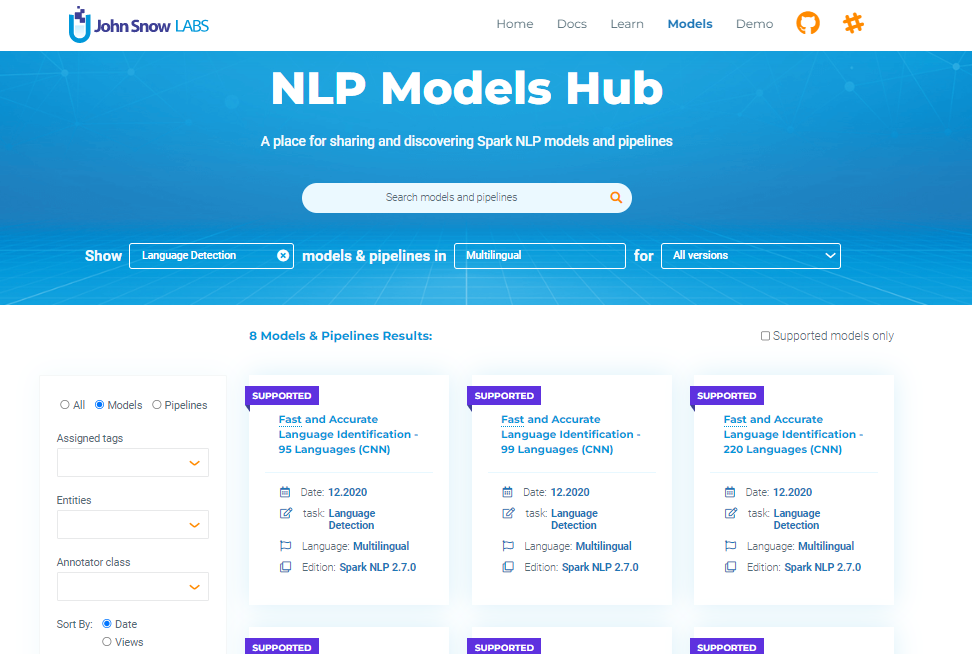


In [ ]:
language_detector = LanguageDetectorDL.pretrained("ld_wiki_tatoeba_cnn_220", "xx")\
    .setInputCols(["document"])\
    .setOutputCol("language")

languagePipeline = Pipeline(stages=[documentAssembler, language_detector])

light_pipeline = LightPipeline(languagePipeline.fit(spark.createDataFrame([['']]).toDF("text")))

result = light_pipeline.annotate("Spark NLP est une bibliothèque de traitement de texte open source pour le traitement avancé du langage naturel pour les langages de programmation Python, Java et Scala.")

ld_wiki_tatoeba_cnn_220 download started this may take some time.
Approximate size to download 8.5 MB
[OK!]


In [ ]:
result['language']

['fr']